In [1]:
# Import Dependencies
# Importing them all at once for ease of reference
# Mandatory
from sqlalchemy import create_engine, text, inspect, func

# ORM imports
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import Column, Integer, String, Float, Boolean
from sqlalchemy.orm import Session
from sqlalchemy.ext.declarative import declarative_base

# Data Science and Visualization
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import datetime as dt

# Create a base using `automap_base()` for reflection
Base = automap_base()

# Reflect Tables into SQLAlchemy ORM
---

In [2]:
# Create the engine to hawaii.sqlite
filepath = 'Resources/hawaii.sqlite'
engine = create_engine(f"sqlite:///{filepath}")

In [3]:
# Use the Base class to reflect the tables in the Hawaii Database
Base.prepare(autoload_with=engine)

In [4]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to the classes
# For the station class
Station = Base.classes.station
Measurement = Base.classes.measurement

In [6]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis
---

In [7]:
# Finding most recent date in the Measurement data set using raw SQL
query = """
        Select date
        From measurement
        Order By date Desc
        Limit 1
        """

date = pd.read_sql(text(query), con=engine)
date

,date
0,2017-08-23


In [8]:
# Finding most recent date in the Measurement data set using ORM
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

In [9]:
# Making the latest date into a datetime
latest_date_str = pd.to_datetime(latest_date)
latest_date_str

DatetimeIndex(['2017-08-23'], dtype='datetime64[ns]', freq=None)

In [10]:
# Finding the year before of the date using DateOffset (gotten from: https://stackoverflow.com/a/31170136/23471668)
year_before = latest_date_str - pd.DateOffset(years=1)

In [11]:
# Convert the year_before DatetimeIndex into a date; code from Xpert
year_before_str = year_before.strftime('%Y-%m-%d')
year_before_str[0]

'2016-08-23'

In [12]:
# Finding all values in the range year_before to latest_date_str (because it's an index, need to call the first item)
query_results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_before_str[0]).all()

In [13]:
# Create the new DataFrame
# Set column names
column_names = ['date', 'precipitation']

last_year_precip = pd.DataFrame(query_results, columns=column_names).sort_values(by='date')

In [36]:
# Sets xticks dependent on the most recent date in the data set
# Ensures dates aren't hardcoded into the plot
xticks = [(latest_date_str - pd.DateOffset(months=12)).strftime('%Y-%m-%d')[0], 
          (latest_date_str - pd.DateOffset(months=9)).strftime('%Y-%m-%d')[0],
          (latest_date_str - pd.DateOffset(months=6)).strftime('%Y-%m-%d')[0],
          (latest_date_str - pd.DateOffset(months=3)).strftime('%Y-%m-%d')[0],
          latest_date_str.strftime('%Y-%m-%d')[0]]

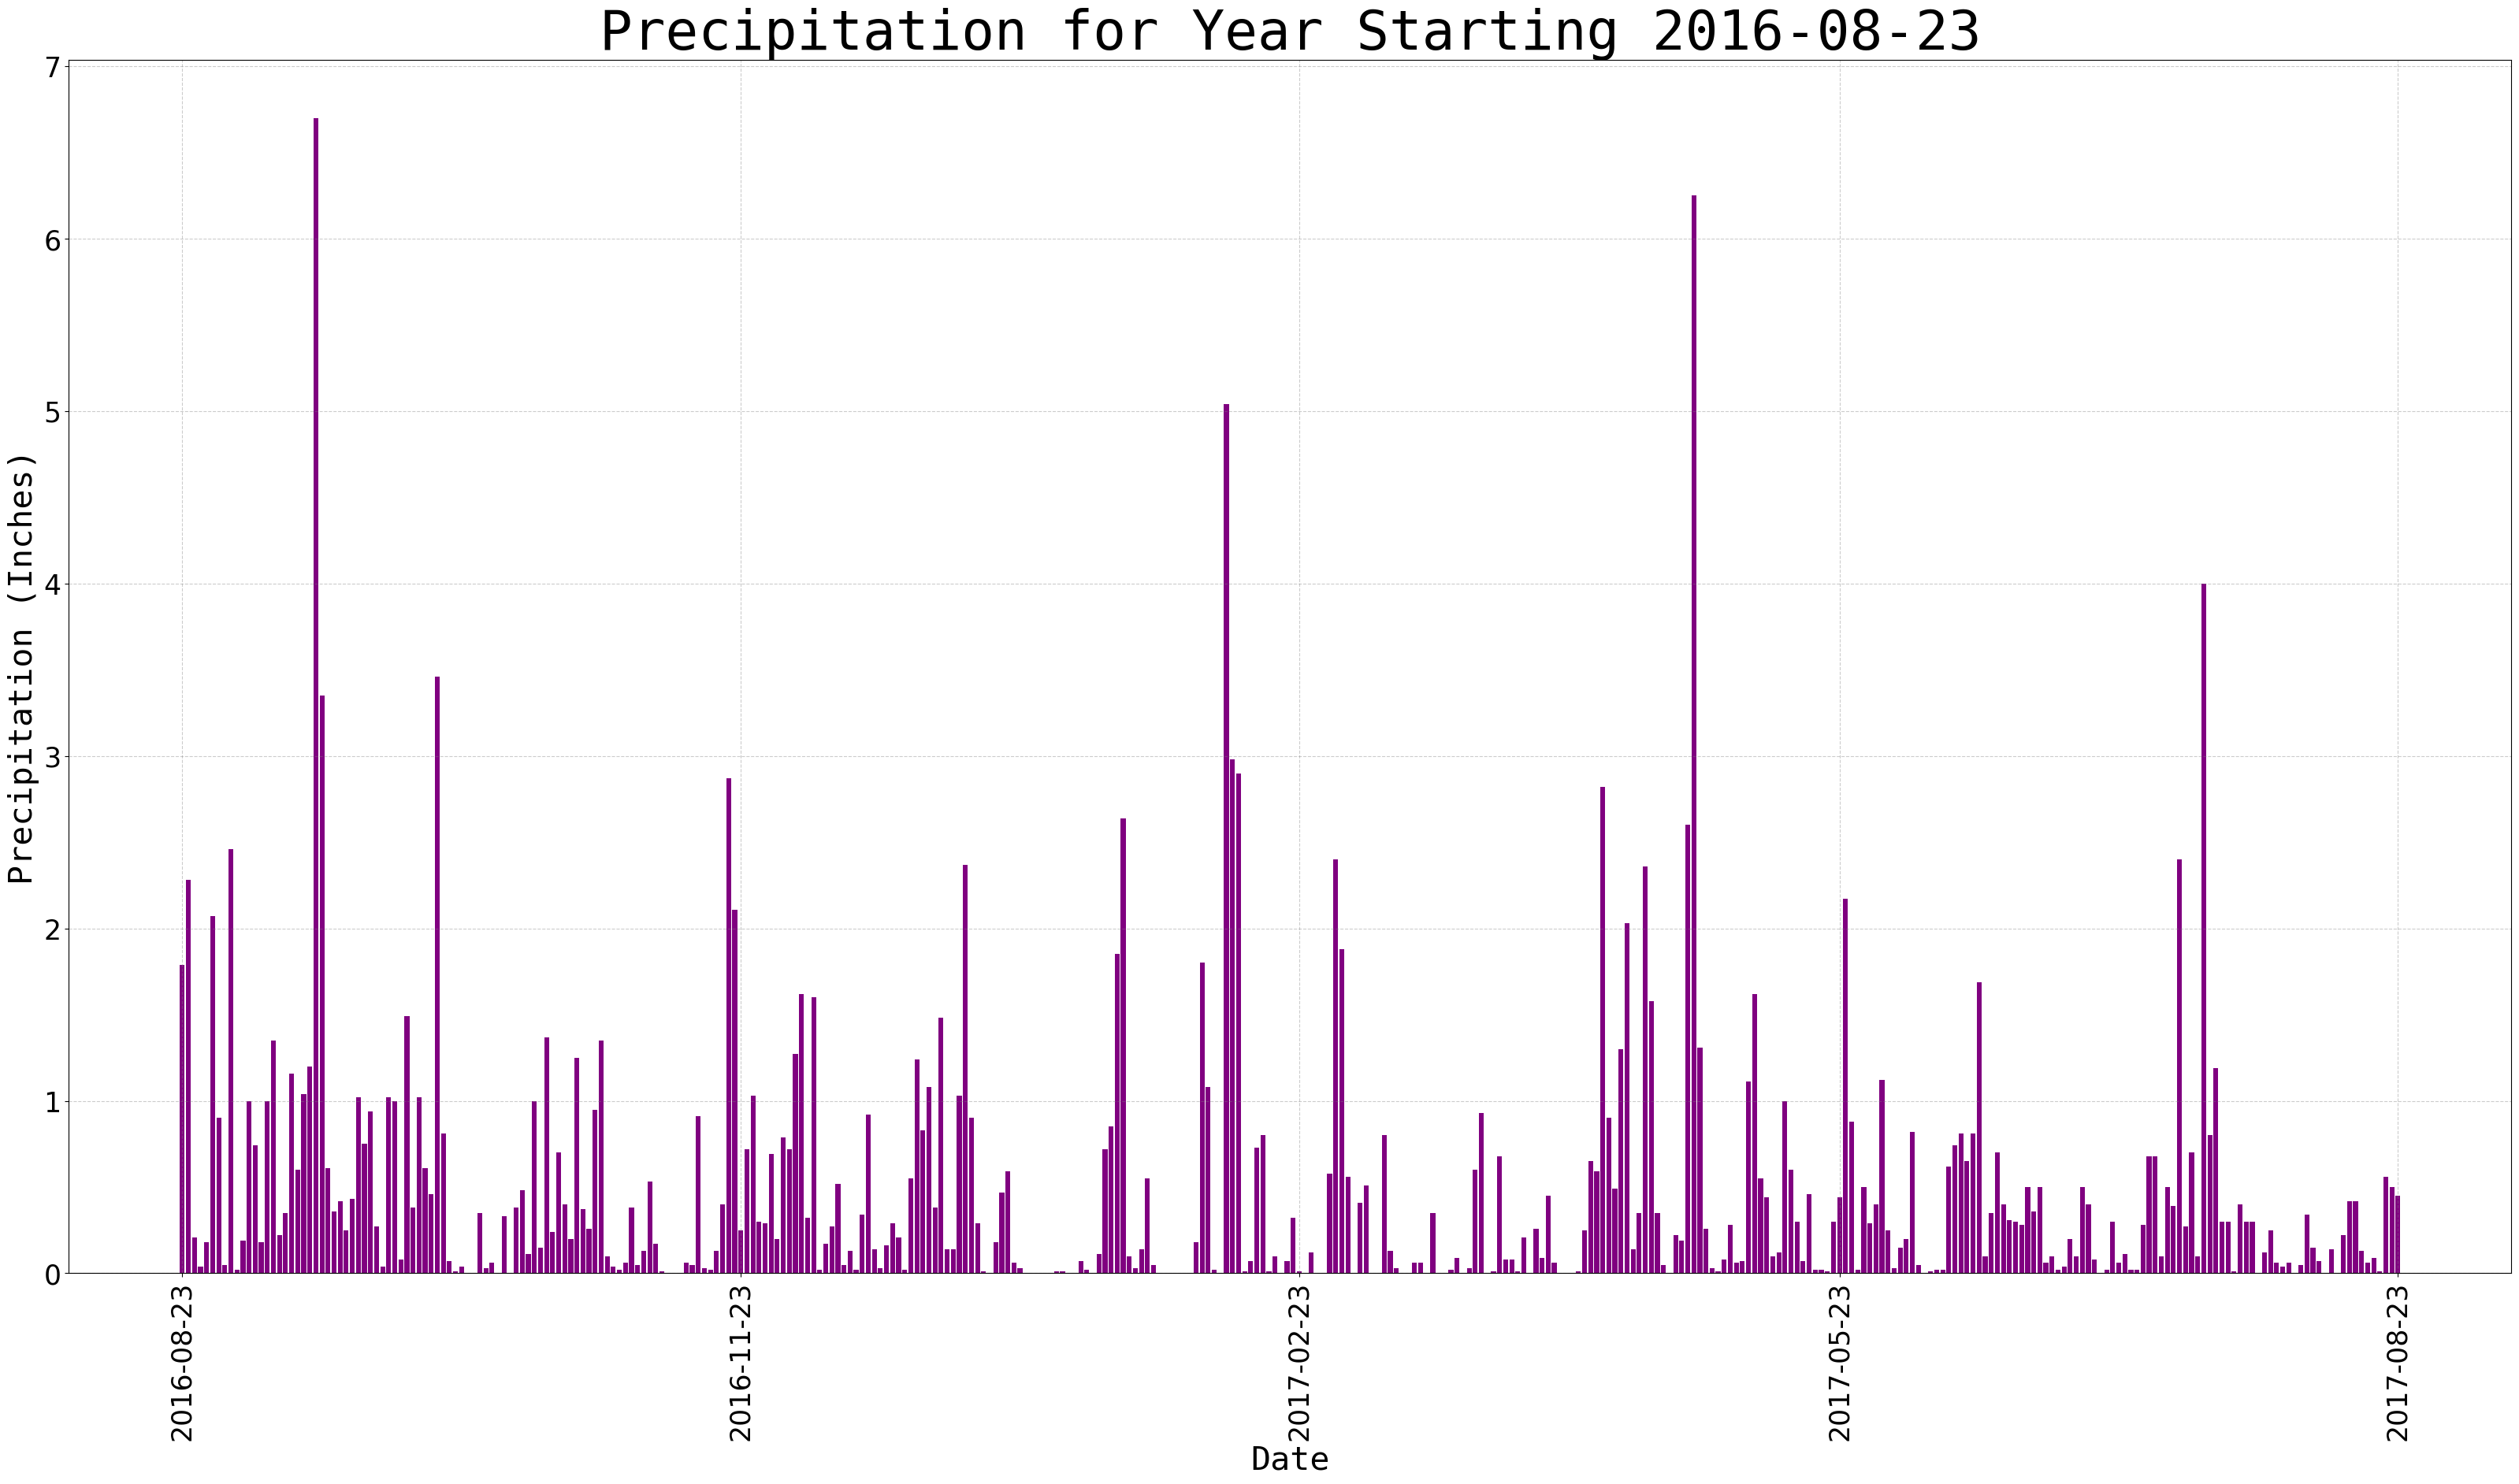

In [31]:
# Make the plot
x = last_year_precip.date
y = last_year_precip.precipitation

# Step 2: Create the Canvas
plt.figure(figsize=(40,20))

# Step 3: Create the skeleton plot
plt.bar(x, y, color="Purple")

# Step 4: Customization
# No need to include x-label since its obvious
plt.ylabel("Precipitation (Inches)", fontsize=30, fontfamily="monospace")
plt.xlabel("Date", fontsize=30, fontfamily="monospace")
plt.title(f"Precipitation for Year Starting {year_before_str[0]}", fontsize=50, fontfamily="monospace")
plt.yticks(fontsize=25)
plt.xticks(fontsize=25, ticks=xticks, rotation=90)
plt.grid(color="gray", linestyle="--", alpha=.4)


# Step 5: Show/Save the plot
plt.show()

In [15]:
# Calculate the summary statistics
last_year_precip.precipitation.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis
---

In [16]:
# Get number of stations in the dataset
session.query(Measurement.station.distinct()).count()

9

In [17]:
# Find the most active stations in the dataset
# Get number of stations in the dataset
station_act = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
display (station_act)

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Get the max, min, and average Temperatures for the most active station
ma_temp_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == station_act[0][0]).all()
display (ma_temp_stats)

[(54.0, 85.0, 71.66378066378067)]

In [20]:
# Gets the station name for the most active station
station_act[0][0]

# The last year precipitation values
query_results_ma = session.query(Measurement.tobs).filter(Measurement.date >= year_before_str[0], Measurement.station == station_act[0][0]).all()

# Make the DataFrame
column_names = ['tobs']

last_year_temp_ma = pd.DataFrame(query_results_ma, columns=column_names)

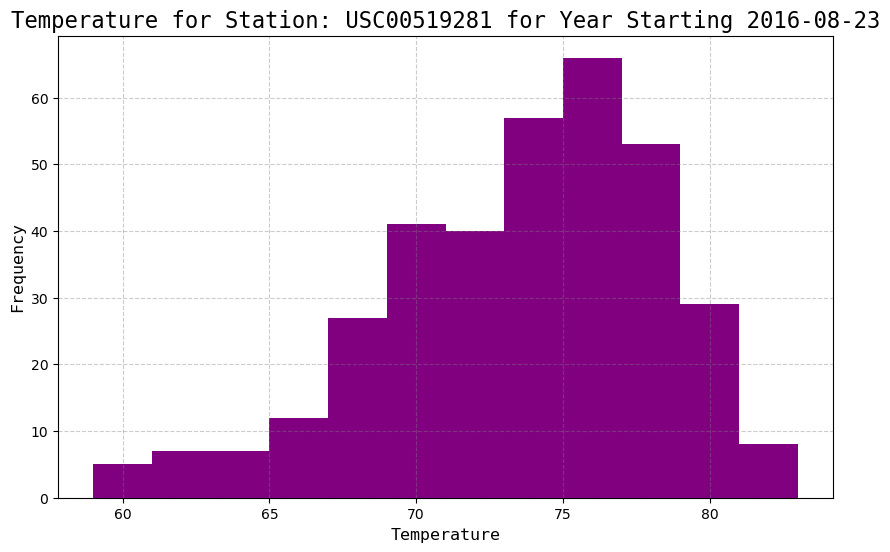

In [21]:
# Make the histogram
# Make the plot
x = last_year_temp_ma.tobs

# Step 2: Create the Canvas
plt.figure(figsize=(10, 6))

# Step 3: Create the skeleton plot
plt.hist(x, bins=12, color="Purple")

# Step 4: Customization
# No need to include x-label since its obvious
plt.ylabel("Frequency", fontsize=12, fontfamily="monospace")
plt.xlabel("Temperature", fontsize=12, fontfamily="monospace")
plt.title(f"Temperature for Station: {station_act[0][0]} for Year Starting {year_before_str[0]}", fontsize=16, fontfamily="monospace")
plt.grid(color="gray", linestyle="--", alpha=.4)


# Step 5: Show/Save the plot
plt.show()

# Close Session
---

In [22]:
# Close Session
session.close()